# Replica exchange Monte Carlo

We consider exactly the same 1D ising model as in the previous section.
In this section, we will how we implement the replica exchange Monte Carlo method.

In [91]:
@show VERSION
using BenchmarkTools, Random, Revise

VERSION = v"1.5.2"


## Preparation
We now repeat the implementation of the single-spin-flip update and measurement given in the previous section.
You can save these codes in mc.jl and include it in the following cell.
Here, we use **includet** in Revise.jl instead of **include** in the standard library.
**includet** tracks any changes the included file and reload the code if any.

Please download [mc.jl](./mc.jl) and [meas.jl](./meas.jl) and save them in your working directory.

In [96]:
includet("mc.jl")
includet("meas.jl")

In [100]:
function solve!(ss, acc, β, nsteps, ntherm_steps, interval_meas, rng)
    # 1 Monte Carlo step = 1 sweep through the system
    num_sweeps_per_step = 1
    
    # Thermalization steps
    MC.update!(ss, β, ntherm_steps, rng)
    
    # Measurement steps
    for istep in 1:nsteps
        MC.update!(ss, β, num_sweeps_per_step, rng)
        if mod(istep, interval_meas) != 0
            continue
        end
        Meas.add!(acc, "E", Float64(ss.energy))
        Meas.add!(acc, "E2", Float64(ss.energy)^2)
        MC.sanity_check(ss)
    end
end

solve! (generic function with 1 method)

### Replica Exchange Monte Carlo

In the replica exchange Monte Carlo method,
exchanges between two replicas with different inverse temperatures $\beta_1$ and $\beta_2$ are accepted with the probability

$$
P_\mathrm{ex} = \mathrm{min}\Big\{1, e^{(\beta_1-\beta_2)(E_1 - E_2)} \Big\},
$$

where $E_1$ and $E_2$ are the energies of the two replicas.

In [35]:
"""
Replica exchante update between the i-th and j-the replicas.
"""
function rex!(βs, replicas, i, j, rng)
    prop_ex = exp((βs[i]-βs[j])*(replicas[i].energy-replicas[j].energy))
    if rand(rng) < prop_ex
        replicas[i], replicas[j] = replicas[j], replicas[i]
    end
end

rex!

In [81]:
function solve_rex!(replicas, accumulators, βs, nsweeps, ntherm, interval_meas, rng)
    if mod(nsweeps, interval_meas) != 0
        error("nsweeps cannot be divided by interval_meas!")
    end
    num_replicas = length(βs)
    
    # Do interval_meas sweeps and one rex step 
    function do_sweeps()
        for i in 1:num_replicas
            MC.update!(replicas[i], βs[i], interval_meas, rng)
        end
        #for i in 1:num_replicas-1
        #    rex!(βs, replicas, i, i+1, rng)
        #end
    end

    # Thermalization steps
    for _ in 1:(ntherm//interval_meas)
        do_sweeps()
    end
    
    # Measurement steps
    for imeas in 1:(nsweeps//interval_meas)
        do_sweeps()
        for i in 1:num_replicas
            Meas.add!(accumulators[i], "E", Float64(replicas[i].energy))
            Meas.add!(accumulators[i], "E2", Float64(replicas[i].energy)^2)
        end
    end
end

solve_rex! (generic function with 1 method)

In [88]:
nsweeps = 10^7
interval_meas = 10
ntherm = nsweeps//10

numβ = 10
Ts_mc = collect(range(0.4, 0.5, length=numβ))
βs = 1 ./ Ts_mc

# Construct nβ replicas and accumulators
replicas = collect((MC.SpinState(s0) for _ in 1:numβ))
accumulators = collect((Meas.Accumulator() for _ in 1:numβ))

solve_rex!(replicas, accumulators, βs, nsweeps, ntherm, interval_meas, rng)

In [89]:
C_mc = collect((Meas.mean(acc, "E2") - Meas.mean(acc, "E")^2 for acc in accumulators)) .* (βs.^2);

Let us compare Monte Carlo results with the exact solution $C/N = \frac{1}{T^2 \cosh^2(1/T)}$.

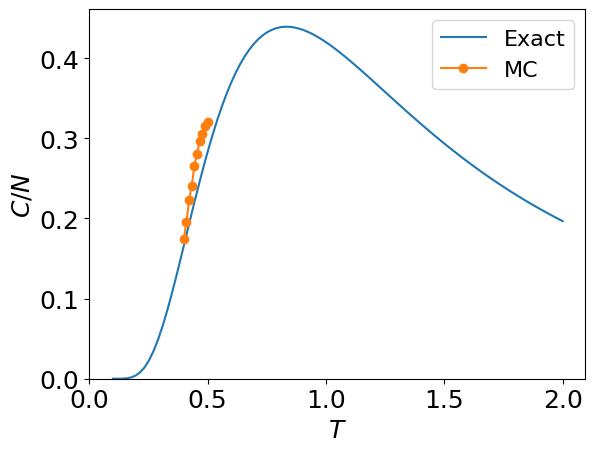

In [90]:
using PyPlot
Ts = range(0.1, 2, length=100)
exact_C(T) = 1/(T * cosh(1/T))^2
plt.plot(Ts, exact_C.(Ts), label="Exact")
plt.plot(Ts_mc, C_mc ./ num_spins, label="MC", marker="o")
plt.xlabel(raw"$T$")
plt.ylabel(raw"$C/N$")
plt.xlim([0, nothing])
plt.ylim([0, nothing])
plt.legend()
;